In [1]:
import os
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from scipy import stats
import plotly.express as px
import toml
import psrc_theme

%matplotlib inline
from IPython.display import display, HTML

# to show plotly figures in quarto HTML file
import plotly.io as pio
pio.renderers.default = "plotly_mimetype+notebook_connected"
pio.templates.default = "simple_white+psrc_color" # set plotly template

input_config = toml.load(os.path.join(os.getcwd(), '..\\..\\..\\..\\configuration', 'input_configuration.toml'))
valid_config = toml.load(os.path.join(os.getcwd(), '..\\..\\..\\..\\configuration', 'validation_configuration.toml'))
emme_config = toml.load(os.path.join(os.getcwd(), '..\\..\\..\\..\\configuration','emme_configuration.toml'))
network_config = toml.load(os.path.join(os.getcwd(), '..\\..\\..\\..\\configuration','network_configuration.toml'))

# create connection
conn = create_engine('sqlite:///../../../../inputs/db/'+input_config['db_name'])

# summary data location
csv_path = os.path.join(valid_config['model_dir'], 'outputs/validation')

# table format
pd.options.display.float_format = '{:0,.0f}'.format
format_percent = "{:,.1%}".format

## VMT

In [2]:
df = pd.read_csv(os.path.join(valid_config['model_dir'], r'outputs/network/county_network.csv'))
df.index = df.county_name
df.loc['Total',:] = df.sum().values
df = df[['VMT','VHT','delay']]
df

,VMT,VHT,delay
county_name,,,
King,"45,054,578","1,448,799","194,412"
Kitsap,"4,293,918","125,097","2,859"
Outside Region,"256,871","5,010",6
Pierce,"17,971,135","548,075","44,284"
Snohomish,"16,539,940","497,155","42,947"
Total,"84,116,442","2,624,136","284,509"


In [3]:
df = pd.read_csv(os.path.join(valid_config['model_dir'], r'outputs/network/county_network.csv'))

df_obs = pd.read_sql("SELECT * FROM observed_vmt WHERE year="+str(input_config['base_year']), con=conn)
df_obs.rename(columns={'vmt': 'observed'}, inplace=True)

df = df[['county_name','VMT']].merge(df_obs, left_on='county_name', right_on='county')
df.rename(columns={'VMT': 'model'}, inplace=True)
df.index = df['county']
df[['observed','model']] = df[['observed','model']].astype('float')

df.loc['Total',:] = df.sum().values

df['% diff'] = (df['model']-df['observed'])/df['observed']
df[['% diff']] = df[['% diff']].applymap(format_percent)
df[['model','observed','% diff']]

,model,observed,% diff
county,,,
King,"45,054,578","43,820,112",2.8%
Kitsap,"4,293,918","4,840,030",-11.3%
Pierce,"17,971,135","17,994,803",-0.1%
Snohomish,"16,539,940","15,825,794",4.5%
Total,"83,859,571","82,480,739",1.7%


## Daily Traffic Counts

In [4]:
df = pd.read_csv(os.path.join(csv_path, 'daily_volume.csv'))
df[['modeled', 'observed']] = df[['modeled', 'observed']].astype('float')
_df = df.groupby('@facilitytype').sum()[['observed', 'modeled']]
_df.loc['Total', :] = _df.sum().values
_df['diff'] = _df['modeled'] - _df['observed']
_df['percent_diff'] = _df['diff'] / _df['observed']
_df[['percent_diff']] = _df[['percent_diff']].applymap(format_percent)
_df

,observed,modeled,diff,percent_diff
@facilitytype,,,,
Arterial,"13,060,004","13,938,278","878,274",6.7%
Collector,"72,096","77,278","5,182",7.2%
Freeway,"46,455,221","44,433,614","-2,021,607",-4.4%
HOV,"246,053","278,147","32,094",13.0%
Ramp,"334,132","259,006","-75,126",-22.5%
Total,"60,167,506","58,986,323","-1,181,183",-2.0%


In [5]:
df = pd.read_csv(os.path.join(csv_path,'daily_volume_county_facility.csv'))
df[['modeled','observed']] = df[['modeled','observed']].astype('float')

_df = df.groupby('county').sum()[['observed','modeled']]
_df.loc['Total',:] = _df.sum().values
_df['diff'] = _df['modeled']-_df['observed']
_df['percent_diff'] = _df['diff']/_df['observed']
_df[['percent_diff']] = _df[['percent_diff']].applymap(format_percent)
_df

,observed,modeled,diff,percent_diff
county,,,,
King,"32,134,146","32,934,499","800,353",2.5%
Kitsap,"3,636,120","2,838,131","-797,989",-21.9%
Pierce,"12,521,558","11,913,041","-608,517",-4.9%
Snohomish,"11,875,682","11,300,652","-575,030",-4.8%
Total,"60,167,506","58,986,323","-1,181,183",-2.0%


## Daily Traffic Scatterplot

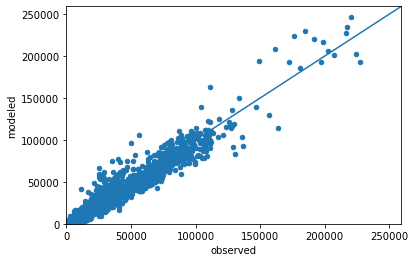

In [6]:
df = pd.read_csv(os.path.join(csv_path,'daily_volume.csv'))
ax = df.plot(kind='scatter', x='observed', y='modeled')
lim = df[['observed','modeled']].max().max()*1.05
ax.set_ylim(0,lim)
ax.set_xlim(0,lim)
x = np.linspace(*ax.get_xlim())
ax.plot(x, x)

In [7]:
slope, intercept, r_value, p_value, std_err = stats.linregress(df['observed'],df['modeled'])
print('r^2: ' + str(r_value))

r^2: 0.9566759614430503


King r^2: 0.9611936130003326
Kitsap r^2: 0.9690664782118945
Pierce r^2: 0.9589349430746898
Snohomish r^2: 0.937754476540925


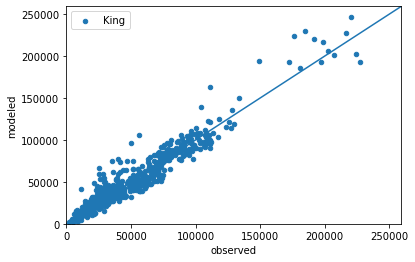

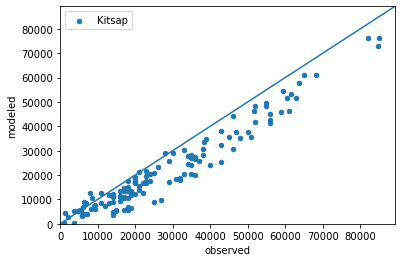

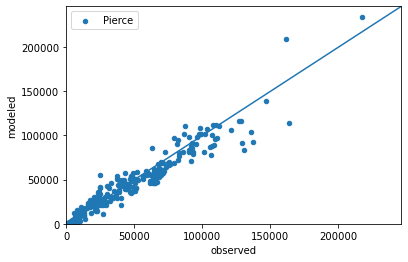

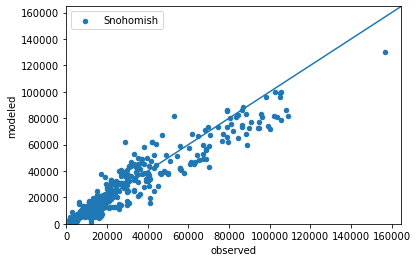

In [8]:
for county in np.unique(df['county']):
    _df = df[df['county'] == county]
    ax = _df.plot(kind='scatter', x='observed', y='modeled', label=county)
    lim = _df[['observed','modeled']].max().max()*1.05
    ax.set_ylim(0,lim)
    ax.set_xlim(0,lim)
    slope, intercept, r_value, p_value, std_err = stats.linregress(_df['observed'],_df['modeled'])
    x = np.linspace(*ax.get_xlim())
    ax.plot(x, x)
    print(str(county) + ' r^2: ' + str(r_value))

In [9]:
df['@facilitytype'].unique()

array(['Freeway', 'Ramp', 'HOV', 'Arterial', 'Collector'], dtype=object)

r^2 Freeway: 0.9471896222381098


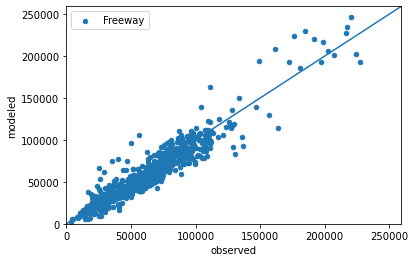

In [10]:
# for factype in ['Freeway','Arterial']:
for factype in ['Freeway']:
    _df = df[df['@facilitytype'] == factype]
    ax = _df.plot(kind='scatter', x='observed', y='modeled', label=factype)
    lim = _df[['observed','modeled']].max().max()*1.05
    ax.set_ylim(0,lim)
    ax.set_xlim(0,lim)
    x = np.linspace(*ax.get_xlim())
    ax.plot(x, x)
    slope, intercept, r_value, p_value, std_err = stats.linregress(_df['observed'],_df['modeled'])
    print('r^2 ' + str(factype) + ': ' + str(r_value))

In [11]:
## hourly volumnes

In [12]:
# df = pd.read_csv(os.path.join(csv_path,'hourly_volume.csv'))
# ax = df.plot(kind='scatter', x='observed', y='modeled')
# lim = df[['observed','modeled']].max().max()*1.05
# ax.set_ylim(0,lim)
# ax.set_xlim(0,lim)
# x = np.linspace(*ax.get_xlim())
# ax.plot(x, x)
# slope, intercept, r_value, p_value, std_err = stats.linregress(df['observed'],df['modeled'])
# print('r^2: ' + str(r_value))

## Screenlines

In [13]:
df = pd.read_csv(os.path.join(csv_path,'screenlines.csv'))
df = df.append(df.sum(numeric_only=True), ignore_index=True)
df.at[df.index[-1], 'name'] = 'TOTAL'
#df.at['C', 'name'] = 10
df['percent_diff'] = df['diff']/df['observed']
df[['percent_diff']] = df[['percent_diff']].applymap(format_percent)
df

,name,observed,modeled,county,diff,percent_diff
0,AUBURN - SOUTH KING,"592,476","520,669",King,"-71,807",-12.1%
1,KENT,"559,335","483,749",King,"-75,586",-13.5%
2,SHIP CANAL,"480,070","516,638",King,"36,568",7.6%
3,SEATTLE - SOUTH OF CBD,"473,322","485,037",King,"11,715",2.5%
4,MILL CREEK,"391,447","381,322",King,"-10,125",-2.6%
5,SOUTH BELLEVUE,"389,700","367,159",King,"-22,541",-5.8%
6,KIRKLAND-REDMOND,"381,663","385,355",King,"3,692",1.0%
7,SEATTLE - NORTH,"356,051","354,768",King,"-1,283",-0.4%
8,TACOMA - EAST OF CBD,"324,463","340,459",Pierce,"15,996",4.9%
9,PARKLAND,"299,722","278,437",Pierce,"-21,285",-7.1%


r^2 : 0.9835706734957919


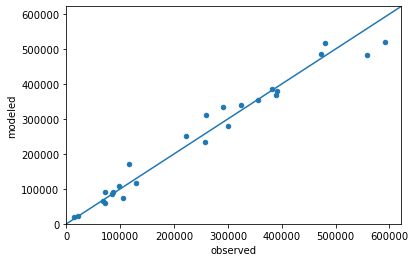

In [14]:
df = df.head(-1)
ax = df.plot(kind='scatter', x='observed', y='modeled')
lim = df[['observed','modeled']].max().max()*1.05
ax.set_ylim(0,lim)
ax.set_xlim(0,lim)
x = np.linspace(*ax.get_xlim())
ax.plot(x, x)
slope, intercept, r_value, p_value, std_err = stats.linregress(df['observed'],df['modeled'])
print('r^2 : ' + str(r_value))

## External Station Volumes

In [15]:
df = pd.read_csv(os.path.join(csv_path,'external_volumes.csv'))
df['percent_diff'] = df['diff']/df['observed']
df[['percent_diff']] = df[['percent_diff']].applymap(format_percent)
df

,external_station,location,county,observed,modeled,diff,percent_diff
0,3733,I-5 to Olympia,Pierce,"132,000","91,793","-40,207",-30.5%
1,3744,I-5 to Mount Vernon,Snohomish,"64,400","48,003","-16,397",-25.5%
2,3739,I-90 @ Snoqualmie Pass,King,"33,800","30,737","-3,063",-9.1%
3,3734,SR-507 to Yelm,Pierce,"21,800","15,064","-6,736",-30.9%
4,3746,SR-532 to Camano Island,Snohomish,"20,700","15,013","-5,687",-27.5%
5,3749,SR-3 to Belfair,Kitsap,"18,400","5,685","-12,715",-69.1%
6,3748,Hood Canal Bridge,Kitsap,"17,600","13,333","-4,267",-24.2%
7,3745,SR-530 N/O Stanwood,Snohomish,"9,100","5,185","-3,915",-43.0%
8,3747,Mukilteo-Clinton Ferry,Snohomish,"6,050","5,935",-115,-1.9%
9,3740,SR-2 @ Stevens Pass,King,"4,600","11,858","7,258",157.8%


r^2 : 0.9844381456256202


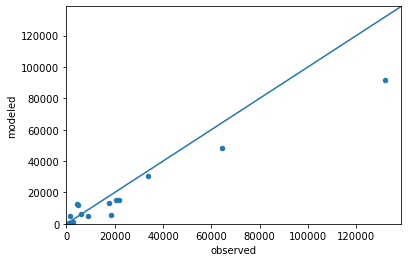

In [16]:
df = df.head(-1)
ax = df.plot(kind='scatter', x='observed', y='modeled')
lim = df[['observed','modeled']].max().max()*1.05
ax.set_ylim(0,lim)
ax.set_xlim(0,lim)
x = np.linspace(*ax.get_xlim())
ax.plot(x, x)
slope, intercept, r_value, p_value, std_err = stats.linregress(df['observed'],df['modeled'])
print('r^2 : ' + str(r_value))